Epoch 1/30
11187/11187 [==============================] - 11s 947us/step - loss: 0.9564 - accuracy: 0.5412 - val_loss: 0.9232 - val_accuracy: 0.5528
Epoch 2/30
11187/11187 [==============================] - 11s 966us/step - loss: 0.9250 - accuracy: 0.5554 - val_loss: 0.9120 - val_accuracy: 0.5619
Epoch 3/30
11187/11187 [==============================] - 11s 972us/step - loss: 0.9190 - accuracy: 0.5597 - val_loss: 0.9081 - val_accuracy: 0.5643
Epoch 4/30
11187/11187 [==============================] - 11s 954us/step - loss: 0.9168 - accuracy: 0.5624 - val_loss: 0.9066 - val_accuracy: 0.5730
Epoch 5/30
11187/11187 [==============================] - 11s 974us/step - loss: 0.9145 - accuracy: 0.5638 - val_loss: 0.9030 - val_accuracy: 0.5728
Epoch 6/30
11187/11187 [==============================] - 12s 1ms/step - loss: 0.9129 - accuracy: 0.5647 - val_loss: 0.9013 - val_accuracy: 0.5702
Epoch 7/30
11187/11187 [==============================] - 10s 908us/step - loss: 0.9116 - accuracy: 0.5657 -

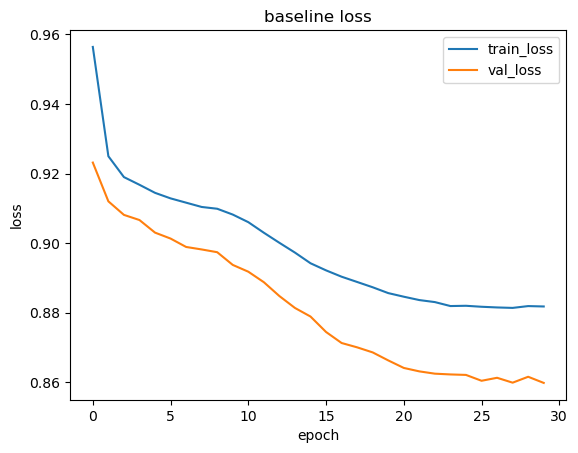

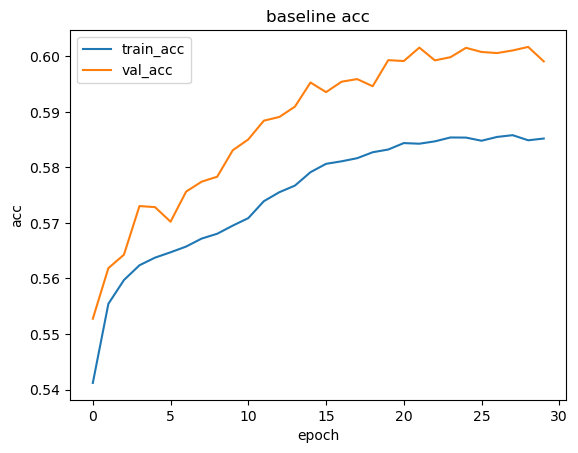

In [4]:
# minimal baseline mlp
# force cpu and disable xla
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow as tf
try:
    tf.config.set_visible_devices([], 'GPU')
except:
    pass
tf.config.optimizer.set_jit(False)

# imports
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import legacy as legacy_optim

# load metadata
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)

# load arrays
X_train = np.load('../artifacts/X_train.npy')
X_val   = np.load('../artifacts/X_val.npy')
y_train = np.load('../artifacts/y_train.npy')
y_val   = np.load('../artifacts/y_val.npy')

# one hot labels
num_classes = len(meta['label_classes'])
y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = keras.utils.to_categorical(y_val, num_classes)

# simple scaling
# ranks are 1 to 13 suits are 0 to 3 scaling helps
X_mean = X_train.mean(axis=0)
X_std  = X_train.std(axis=0) + 1e-8
X_train_s = (X_train - X_mean) / X_std
X_val_s   = (X_val   - X_mean) / X_std
np.save('../artifacts/X_mean.npy', X_mean)
np.save('../artifacts/X_std.npy', X_std)

# model
# input size is number of columns
inp = keras.Input(shape=(X_train.shape[1],))
x = keras.layers.Dense(64, activation='relu')(inp)   # one hidden layer
x = keras.layers.Dropout(0.2)(x)                     # small dropout to reduce overfit
out = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inp, out)

# compile
opt = legacy_optim.Adam()
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              jit_compile=False)

# train
history = model.fit(
    X_train_s, y_train_oh,
    validation_data=(X_val_s, y_val_oh),
    epochs=30,
    batch_size=64,
    verbose=1
)

# plot history
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('baseline loss')
plt.savefig('../artifacts/baseline_loss.png', dpi=150)

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend(); plt.title('baseline acc')
plt.savefig('../artifacts/baseline_acc.png', dpi=150)

# save baseline model and history
model.save('../artifacts/baseline_model.keras')
with open('../artifacts/baseline_history.json','w') as f:
    json.dump(history.history, f)
